# Table of Contents

- [Step 0: Goal Definition](#Step-0:-Goal-Definition)
- [Step 1: Data Acquisition](#Step-1:-Data-Acquisition)
- [Step 2: Data Exploration](#Step-2:-Data-Exploration)
- [Step 3: Preprocessing](#Step-3:-Preprocessing)
- [Step 4: Processing](#Step-4:-Processing)
- [Step 5: Validation](#Step-5:-Validation)    
- [Step 6: Reporting](#Step-6:-Reporting)

# **email Spam Detection**

In [1]:
#------utilities------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#------import for tokens-------
import string
import email
import nltk
import re

# Step 0: Goal Definition


We want to detect/identify spam and/or ham emails by referring to their content.

# Step 1: Data Acquisition

In [4]:
#Setup for text analysis
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')

stopwords = set(nltk.corpus.stopwords.words("english"))
punctuations = list(string.punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
#------utils for tokens-----
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

## Dataset


We will use Enron-Spam 2006 dataset.

In [6]:
train_ds = pd.read_csv('email_origin.csv')
train_ds.head(7)

,label,origin
0,0,Subject: re : wolf - reply - reply - reply\n\n...
1,0,Subject: hilcorp old ocean\n\ni have continued...
2,0,Subject: merchanting metals update\n\nseveral ...
3,0,"Subject: meter 6461 , concorde churchill\n\non..."
4,0,Subject: weekly deal report\n\nattached is the...
5,0,Subject: congratulations !\n\ncongrats on your...
6,0,"Subject: fw : ena ctrc ' s\n\nfyi , kim .\n- -..."


We have printed the first seven rows of our dataset, and we decided to rename the attribute named as 'origin' in 'email'.

In [7]:
train_ds = train_ds.rename(columns={'origin':'email'})
train_ds.head(7)

,label,email
0,0,Subject: re : wolf - reply - reply - reply\n\n...
1,0,Subject: hilcorp old ocean\n\ni have continued...
2,0,Subject: merchanting metals update\n\nseveral ...
3,0,"Subject: meter 6461 , concorde churchill\n\non..."
4,0,Subject: weekly deal report\n\nattached is the...
5,0,Subject: congratulations !\n\ncongrats on your...
6,0,"Subject: fw : ena ctrc ' s\n\nfyi , kim .\n- -..."


# Step 2: Data Exploration

In [8]:
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33702 entries, 0 to 33701
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   33702 non-null  int64 
 1   email   33702 non-null  object
dtypes: int64(1), object(1)
memory usage: 526.7+ KB


In [9]:
train_ds.describe()

,label
count,33702.000000
mean,0.509080
std,0.499925
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [10]:
#we want to see if the DS is balanced
train_ds.label.value_counts()

1    17157
0    16545
Name: label, dtype: int64

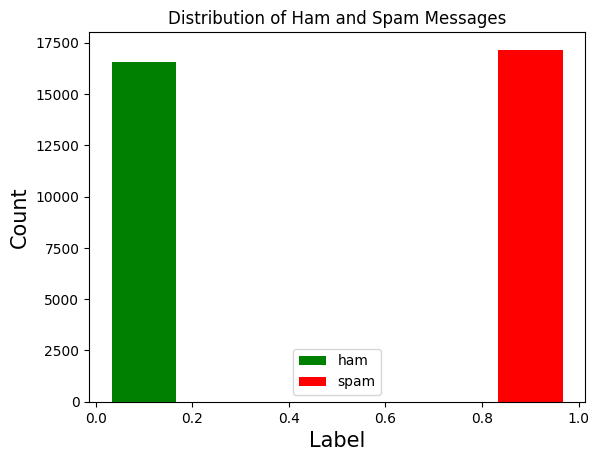

In [11]:
colors = {0: 'green', 1: 'red'}

plt.hist([train_ds[train_ds['label'] == 0]['label'], train_ds[train_ds['label'] == 1]['label']], bins=3, color=[colors[0], colors[1]], label=['ham', 'spam'], align='mid')

plt.xlabel('Label', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Distribution of Ham and Spam Messages')
plt.legend()

plt.show()

In [12]:
#checking null values
train_ds.isnull().sum()

label    0
email    0
dtype: int64

In [13]:
#checking duplicates
train_ds.duplicated().value_counts()

False    30485
True      3217
dtype: int64

# Step 3: Preprocessing

## Data Cleaning

Since we found 3217 duplicates, we proceed to remove them

In [14]:
train_ds.drop_duplicates(inplace=True)

In [15]:
#checking if they were correctly removed
train_ds.duplicated().value_counts()

False    30485
dtype: int64

Since we removed some of the tuples, we check again if our DS is balanced.

In [16]:
train_ds.label.value_counts()

0    15910
1    14575
Name: label, dtype: int64

##Feature Extraction

In [17]:
#these are the special characters that we are considering
special_chars = string.punctuation
print(special_chars)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [18]:
#we want to exploit:
#------------number of words------------
train_ds['num_words'] = train_ds['email'].apply(lambda x: len(word_tokenize(str(x))))

#-----number of special characters-----
train_ds['num_spec_char'] = train_ds['email'].apply(lambda x: sum(1 for char in str(x) if char in special_chars))

#-------------total length-------------
train_ds['total_len'] = train_ds['email'].apply(lambda x: len(str(x)))

#---------number of hyperlinks---------
train_ds['num_links'] = train_ds['email'].str.count('http')

#-----------number of digits-----------
train_ds['num_digits'] = train_ds['email'].apply(lambda x: sum(1 for char in str(x) if char in string.digits))

train_ds

,label,email,num_words,num_spec_char,total_len,num_links,num_digits
0,0,Subject: re : wolf - reply - reply - reply\n\n...,447,184,1760,0,60
1,0,Subject: hilcorp old ocean\n\ni have continued...,137,22,633,0,22
2,0,Subject: merchanting metals update\n\nseveral ...,636,50,3834,0,23
3,0,"Subject: meter 6461 , concorde churchill\n\non...",148,35,658,0,39
4,0,Subject: weekly deal report\n\nattached is the...,34,8,166,0,16
...,...,...,...,...,...,...,...
33696,1,"Subject: 18 - refinance today , as low as 3 . ...",57,13,226,0,9
33697,1,Subject: friendly notification\n\nthis is our ...,115,13,582,0,3
33698,1,Subject: i promised to help 5000 people\n\nple...,30,5,165,0,16
33700,1,Subject: work\n\nin virtue of my office as ass...,348,166,1396,0,60


In [19]:
rows_with_links = train_ds.loc[train_ds['num_links'] > 0]
print(rows_with_links[['email', 'num_links']])

                                                   email  num_links
12     Subject: re : > - lko 40401\n\nnothing . i wil...          3
16     Subject: iafe membership\n\ndear colleague :\n...          1
24     Subject: spring 2001 module and calendar sched...          2
34     Subject: confidential folder to safely pass in...          1
35     Subject: participation in super saturday\n\nas...          1
...                                                  ...        ...
33682  Subject: hiv viruses ? check this site out . t...          2
33692  Subject: hampshire\n\nmcmillan ,\ngovenment do...          1
33693  Subject: your site needs a mass marketing prog...          2
33694  Subject: your free search engine report\n\nsea...          1
33695  Subject: lose your weight . new weightloss los...          1

[5686 rows x 2 columns]


##Graphs

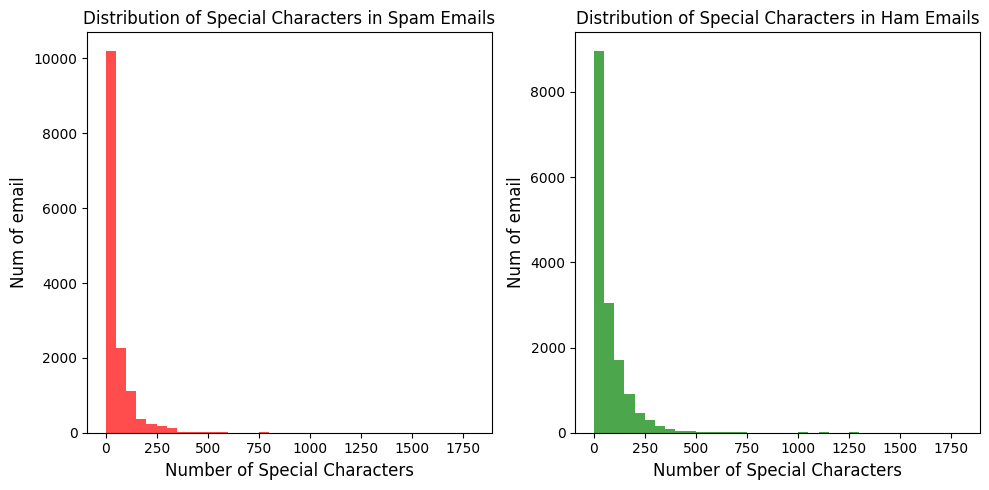

In [20]:
#distribution of special characters in spam/ham mail
x_start, x_stop, x_step = 0, 1800, 50
x_range = range(x_start, x_stop + x_step, x_step)
plt.figure(figsize=(10, 5))

#ham mail
plt.subplot(1, 2, 2)
plt.hist(train_ds[train_ds['label'] == 0]['num_spec_char'], color='green', bins=x_range, alpha=0.7, density = False)
plt.title('Distribution of Special Characters in Ham Emails')
plt.xlabel('Number of Special Characters', fontsize=12)
plt.ylabel('Num of email', fontsize=12)

#spam mail
plt.subplot(1, 2, 1)
plt.hist(train_ds[train_ds['label'] == 1]['num_spec_char'], color='red', bins=x_range, alpha=0.7, density = False)
plt.title('Distribution of Special Characters in Spam Emails')
plt.xlabel('Number of Special Characters', fontsize=12)
plt.ylabel('Num of email', fontsize=12)

plt.tight_layout()
plt.show()

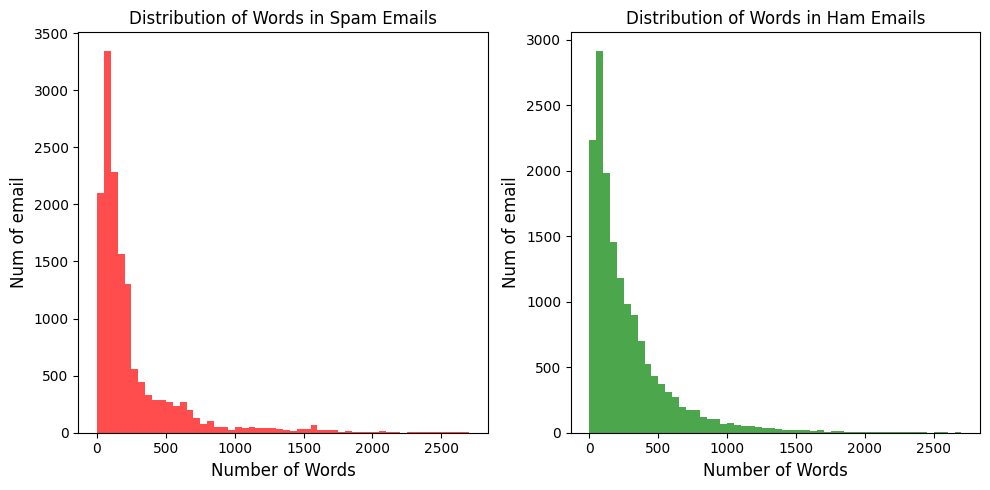

In [21]:
#distribution of the number of words in spam/ham mail
x_start, x_stop, x_step = 0, 2700, 50
x_range = range(x_start, x_stop + x_step, x_step)
plt.figure(figsize=(10, 5))

#ham mail
plt.subplot(1, 2, 2)
plt.hist(train_ds[train_ds['label'] == 0]['num_words'], color='green', bins=x_range, alpha=0.7, density = False)
plt.title('Distribution of Words in Ham Emails')
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Num of email', fontsize=12)

#spam mail
plt.subplot(1, 2, 1)
plt.hist(train_ds[train_ds['label'] == 1]['num_words'], color='red', bins=x_range, alpha=0.7, density = False)
plt.title('Distribution of Words in Spam Emails')
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Num of email', fontsize=12)

plt.tight_layout()
plt.show()

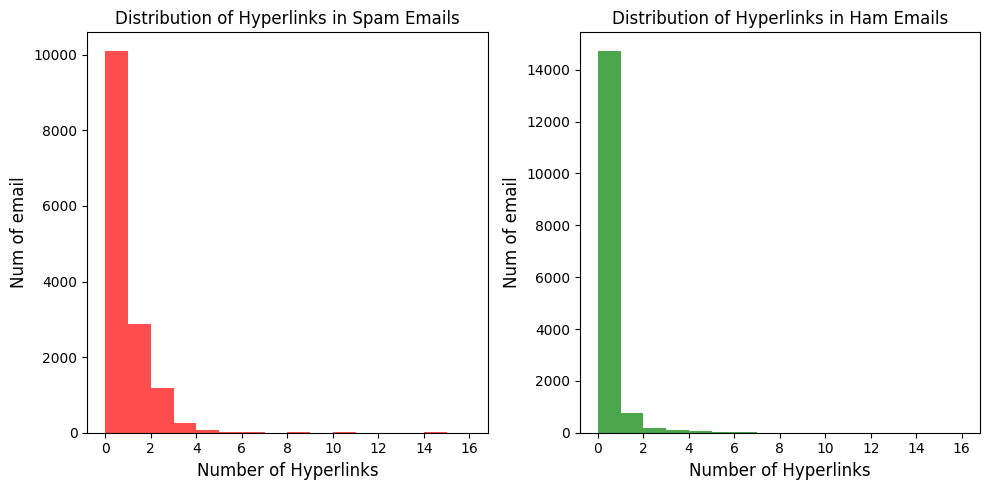

In [22]:
#distribution of the number of hyperlinks in spam/ham mail
x_start, x_stop, x_step = 0, 16, 1
x_range = range(x_start, x_stop + x_step, x_step)
plt.figure(figsize=(10, 5))

#ham mail
plt.subplot(1, 2, 2)
plt.hist(train_ds[train_ds['label'] == 0]['num_links'], color='green', bins=x_range, alpha=0.7, density = False)
plt.title('Distribution of Hyperlinks in Ham Emails')
plt.xlabel('Number of Hyperlinks', fontsize=12)
plt.ylabel('Num of email', fontsize=12)

#spam mail
plt.subplot(1, 2, 1)
plt.hist(train_ds[train_ds['label'] == 1]['num_links'], color='red', bins=x_range, alpha=0.7, density = False)
plt.title('Distribution of Hyperlinks in Spam Emails')
plt.xlabel('Number of Hyperlinks', fontsize=12)
plt.ylabel('Num of email', fontsize=12)

plt.tight_layout()
plt.show()

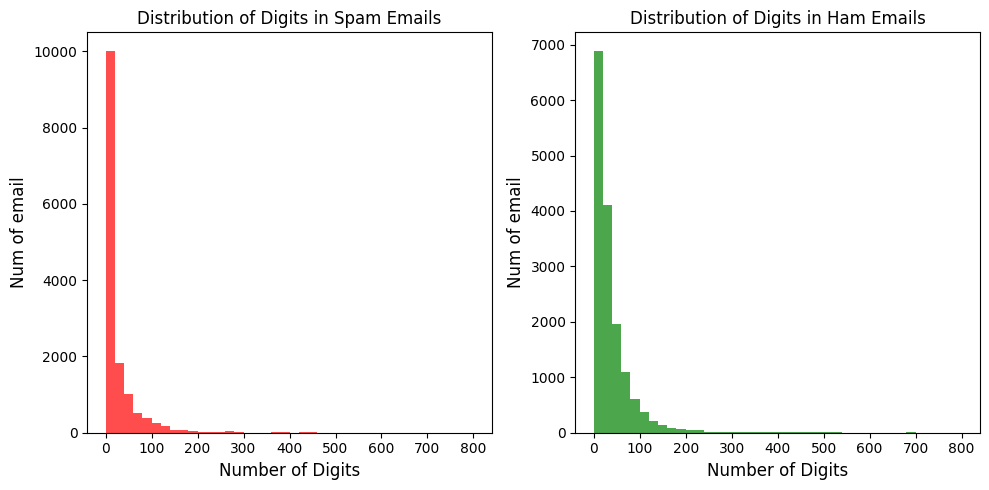

In [23]:
#distribution of the number of words in spam/ham mail
x_start, x_stop, x_step = 0, 800, 20
x_range = range(x_start, x_stop + x_step, x_step)
plt.figure(figsize=(10, 5))

#ham mail
plt.subplot(1, 2, 2)
plt.hist(train_ds[train_ds['label'] == 0]['num_digits'], color='green', bins=x_range, alpha=0.7, density = False)
plt.title('Distribution of Digits in Ham Emails')
plt.xlabel('Number of Digits', fontsize=12)
plt.ylabel('Num of email', fontsize=12)

#spam mail
plt.subplot(1, 2, 1)
plt.hist(train_ds[train_ds['label'] == 1]['num_digits'], color='red', bins=x_range, alpha=0.7, density = False)
plt.title('Distribution of Digits in Spam Emails')
plt.xlabel('Number of Digits', fontsize=12)
plt.ylabel('Num of email', fontsize=12)

plt.tight_layout()
plt.show()

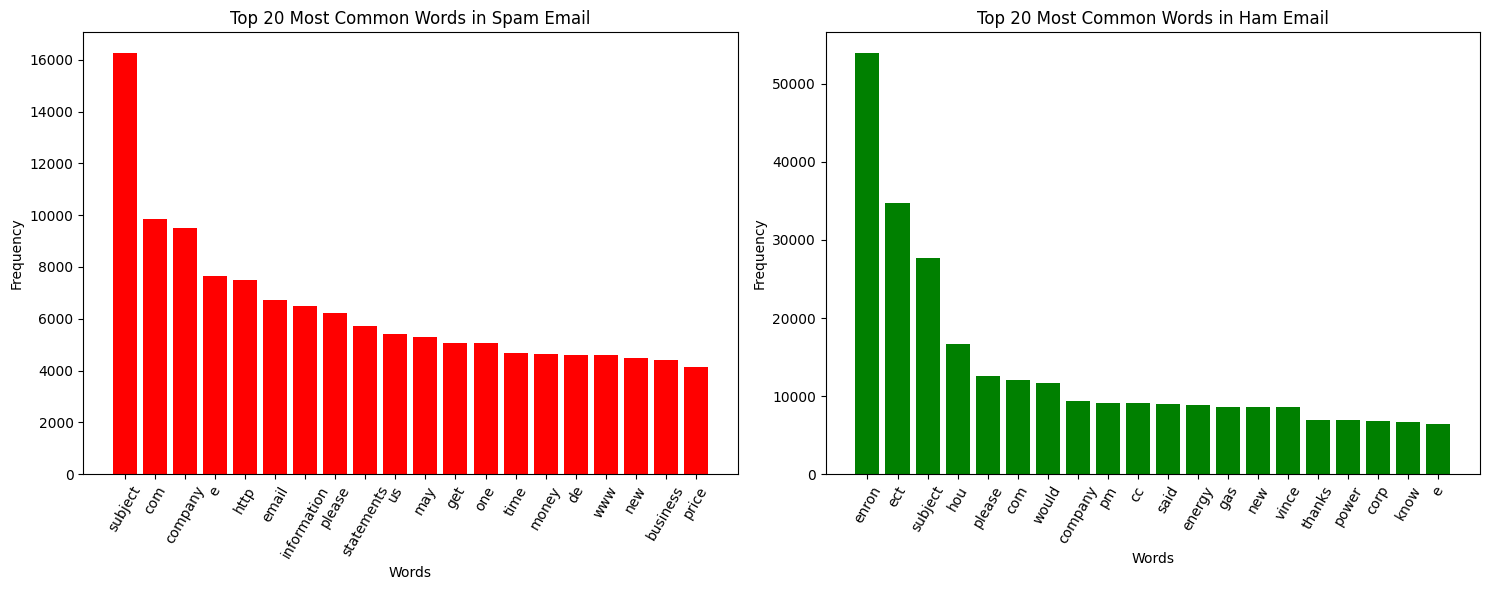

In [24]:
from nltk import FreqDist

#splitting train_ds into ham and spam
ham_df = train_ds[train_ds['label'] == 0]
spam_df = train_ds[train_ds['label'] == 1]

#applying tokenization and removal of all the stopwords (for ham)
ham_text = ' '.join(ham_df['email'])
ham_tokens = word_tokenize(ham_text)
ham_filtered_tokens = [word.lower() for word in ham_tokens if word.isalpha() and word.lower() not in stopwords]
ham_fdist = FreqDist(ham_filtered_tokens)
ham_top_words = ham_fdist.most_common(20)

#applying tokenization and removal of all the stopwords (for spam)
spam_text = ' '.join(spam_df['email'])
spam_tokens = word_tokenize(spam_text)
spam_filtered_tokens = [word.lower() for word in spam_tokens if word.isalpha() and word.lower() not in stopwords]
spam_fdist = FreqDist(spam_filtered_tokens)
spam_top_words = spam_fdist.most_common(20)

#utility variables for the plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax = axes[1]
ham_words, ham_counts = zip(*ham_top_words)
ax.bar(ham_words, ham_counts, color='green')
ax.set_title('Top 20 Most Common Words in Ham Email')
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')
ax.tick_params(axis='x', rotation=60)

ax = axes[0]
spam_words, spam_counts = zip(*spam_top_words)
ax.bar(spam_words, spam_counts, color='red')
ax.set_title('Top 20 Most Common Words in Spam Email')
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')
ax.tick_params(axis='x', rotation=60)

plt.tight_layout()
plt.show()

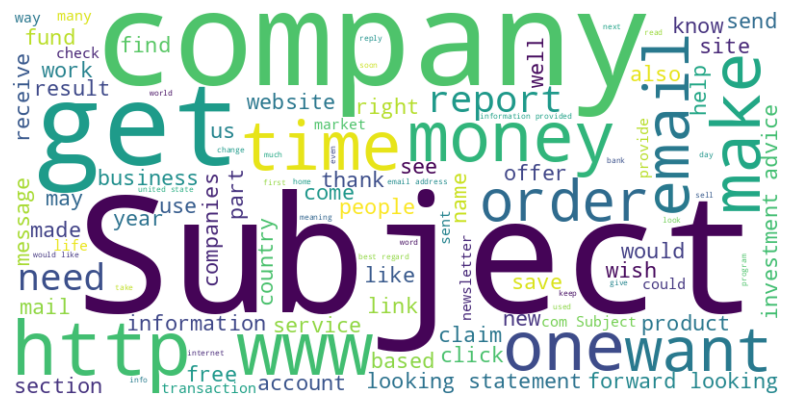

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join(spam_df['email'])

#in this wordcloud we're considering the 100 most common word in spam email
wordcloud = WordCloud(width=800, height=400, max_words=100, min_word_length=2, stopwords=set(stopwords), background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  #this command just removes the axis
plt.show()

In [26]:
from sklearn.model_selection import train_test_split

#splitting dataset into training set(70%) and test set(30%)
X_train, X_test, Y_train, Y_test = train_test_split(train_ds['email'], train_ds['label'], test_size=0.3, stratify=train_ds['label'])

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

#fit and transform training data
vectorizer = CountVectorizer(stop_words = 'english')
X_train_tf = vectorizer.fit_transform(X_train)

#transform text data
X_test_tf = vectorizer.transform(X_test)

# Step 4: Processing

We started by using the hold out approach (70% training set and 30% test set) on five different classifiers that are:

MultinomialNB, Logistic Regression, SVC, Decision Tree, Random Forest.

Classification accuracy 98.6%
--------------------------
Confusion matrix:
 [[4718   55]
 [  77 4296]]
--------------------------
              precision    recall  f1-score   support

        spam       0.98      0.99      0.99      4773
         ham       0.99      0.98      0.98      4373

    accuracy                           0.99      9146
   macro avg       0.99      0.99      0.99      9146
weighted avg       0.99      0.99      0.99      9146



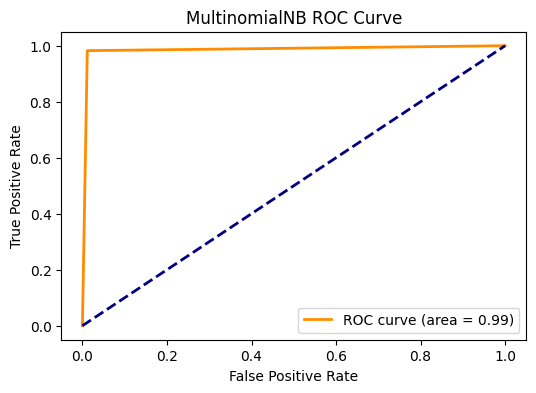

In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, make_scorer, confusion_matrix, roc_curve, auc

mnb = MultinomialNB()
mnb.fit(X_train_tf, Y_train)
Y_res = mnb.predict(X_test_tf)

#we are using False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(Y_test, Y_res)
roc_auc = auc(fpr, tpr)

#utility variables for final table
mnb_accuracy = format(accuracy_score(Y_test, Y_res))
mnb_precision = format(precision_score(Y_test, Y_res))
mnb_recall = format(recall_score(Y_test, Y_res))
mnb_f1 = format(f1_score(Y_test, Y_res))

print('Classification accuracy {:.1%}'.format(accuracy_score(Y_test, Y_res)))
print("--------------------------")
print("Confusion matrix:\n", confusion_matrix(Y_test, Y_res))
print("--------------------------")
print(classification_report(Y_test, Y_res, target_names=['spam', 'ham']))

#printing roc curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MultinomialNB ROC Curve')
plt.legend(loc='lower right')
plt.show()

Classification accuracy 98.7%
--------------------------
Confusion matrix:
 [[4690   83]
 [  32 4341]]
--------------------------
              precision    recall  f1-score   support

        spam       0.99      0.98      0.99      4773
         ham       0.98      0.99      0.99      4373

    accuracy                           0.99      9146
   macro avg       0.99      0.99      0.99      9146
weighted avg       0.99      0.99      0.99      9146



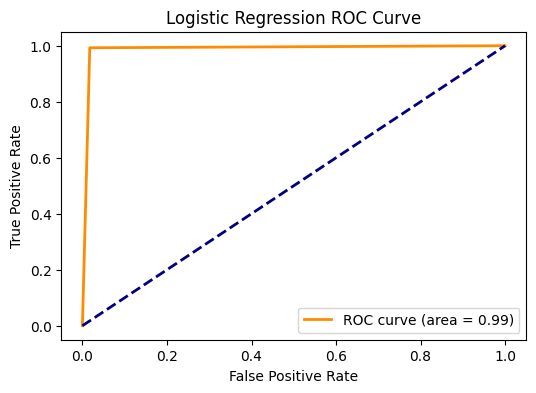

In [31]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=200)
lr.fit(X_train_tf, Y_train)
Y_res = lr.predict(X_test_tf)

#we are using False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(Y_test, Y_res)
roc_auc = auc(fpr, tpr)

#utility variables for final table
lr_accuracy = format(accuracy_score(Y_test, Y_res))
lr_precision = format(precision_score(Y_test, Y_res))
lr_recall = format(recall_score(Y_test, Y_res))
lr_f1 = format(f1_score(Y_test, Y_res))

print('Classification accuracy {:.1%}'.format(accuracy_score(Y_test, Y_res)))
print("--------------------------")
print("Confusion matrix:\n", confusion_matrix(Y_test, Y_res))
print("--------------------------")
print(classification_report(Y_test, Y_res, target_names=['spam', 'ham']))

#printing roc curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc='lower right')
plt.show()

Classification accuracy 96.3%
--------------------------
Confusion matrix:
 [[4479  294]
 [  43 4330]]
--------------------------
              precision    recall  f1-score   support

        spam       0.99      0.94      0.96      4773
         ham       0.94      0.99      0.96      4373

    accuracy                           0.96      9146
   macro avg       0.96      0.96      0.96      9146
weighted avg       0.96      0.96      0.96      9146



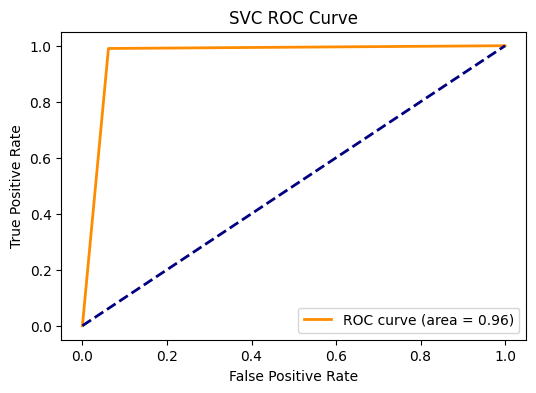

In [32]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train_tf, Y_train)
Y_res = svc.predict(X_test_tf)

#we are using False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(Y_test, Y_res)
roc_auc = auc(fpr, tpr)

#utility variables for final table
svc_accuracy = format(accuracy_score(Y_test, Y_res))
svc_precision = format(precision_score(Y_test, Y_res))
svc_recall = format(recall_score(Y_test, Y_res))
svc_f1 = format(f1_score(Y_test, Y_res))

print('Classification accuracy {:.1%}'.format(accuracy_score(Y_test, Y_res)))
print("--------------------------")
print("Confusion matrix:\n", confusion_matrix(Y_test, Y_res))
print("--------------------------")
print(classification_report(Y_test, Y_res, target_names=['spam', 'ham']))

#printing roc curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVC ROC Curve')
plt.legend(loc='lower right')
plt.show()

Classification accuracy 95.4%
--------------------------
Confusion matrix:
 [[4568  205]
 [ 220 4153]]
--------------------------
              precision    recall  f1-score   support

        spam       0.95      0.96      0.96      4773
         ham       0.95      0.95      0.95      4373

    accuracy                           0.95      9146
   macro avg       0.95      0.95      0.95      9146
weighted avg       0.95      0.95      0.95      9146



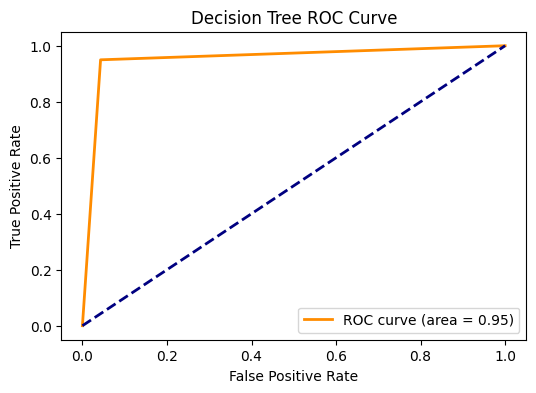

In [33]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dt = DecisionTreeClassifier()
dt.fit(X_train_tf, Y_train)
Y_res = dt.predict(X_test_tf)

#we are using False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(Y_test, Y_res)
roc_auc = auc(fpr, tpr)

#utility variables for final table
dt_accuracy = format(accuracy_score(Y_test, Y_res))
dt_precision = format(precision_score(Y_test, Y_res))
dt_recall = format(recall_score(Y_test, Y_res))
dt_f1 = format(f1_score(Y_test, Y_res))

print('Classification accuracy {:.1%}'.format(accuracy_score(Y_test, Y_res)))
print("--------------------------")
print("Confusion matrix:\n", confusion_matrix(Y_test, Y_res))
print("--------------------------")
print(classification_report(Y_test, Y_res, target_names=['spam', 'ham']))

#printing roc curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.legend(loc='lower right')
plt.show()

Classification accuracy 98.3%
--------------------------
Confusion matrix:
 [[4690   83]
 [  74 4299]]
--------------------------
              precision    recall  f1-score   support

        spam       0.98      0.98      0.98      4773
         ham       0.98      0.98      0.98      4373

    accuracy                           0.98      9146
   macro avg       0.98      0.98      0.98      9146
weighted avg       0.98      0.98      0.98      9146



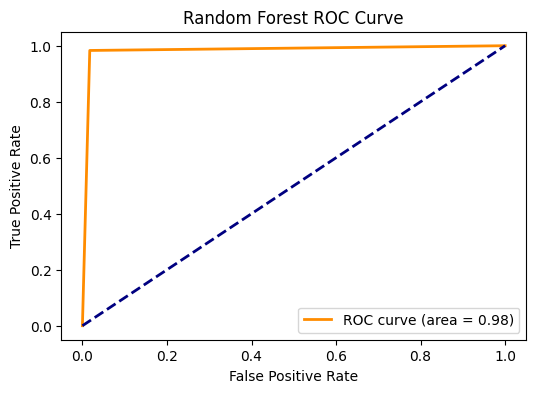

In [34]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train_tf, Y_train)
Y_res = rfc.predict(X_test_tf)

#we are using False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(Y_test, Y_res)
roc_auc = auc(fpr, tpr)

#utility variables for final table
rfc_accuracy = format(accuracy_score(Y_test, Y_res))
rfc_precision = format(precision_score(Y_test, Y_res))
rfc_recall = format(recall_score(Y_test, Y_res))
rfc_f1 = format(f1_score(Y_test, Y_res))

print('Classification accuracy {:.1%}'.format(accuracy_score(Y_test, Y_res)))
print("--------------------------")
print("Confusion matrix:\n", confusion_matrix(Y_test, Y_res))
print("--------------------------")
print(classification_report(Y_test, Y_res, target_names=['spam', 'ham']))

#printing roc curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [35]:
from tabulate import tabulate

classifiers = ['Multinomial Naive Bayesian', 'Logistic Regression', 'Support Vector Machine', 'Decision Tree Classifier', 'Random Forest Classifier']

#final table for comparing metrics of all the classifiers
accuracy_scores = [mnb_accuracy[0:6], lr_accuracy[0:6], svc_accuracy[0:6], dt_accuracy[0:6], rfc_accuracy[0:6]]

#accuracy table
accuracy_list = list(zip(classifiers, accuracy_scores))
accuracy_table = tabulate(accuracy_list, headers=['Classifier', 'Accuracy Score'], tablefmt='rounded_grid')

print(accuracy_table)

╭────────────────────────────┬──────────────────╮
│ Classifier                 │   Accuracy Score │
├────────────────────────────┼──────────────────┤
│ Multinomial Naive Bayesian │           0.9855 │
├────────────────────────────┼──────────────────┤
│ Logistic Regression        │           0.9874 │
├────────────────────────────┼──────────────────┤
│ Support Vector Machine     │           0.9631 │
├────────────────────────────┼──────────────────┤
│ Decision Tree Classifier   │           0.9535 │
├────────────────────────────┼──────────────────┤
│ Random Forest Classifier   │           0.9828 │
╰────────────────────────────┴──────────────────╯


In [36]:
#precision table
precision_scores = [mnb_precision[0:6], lr_precision[0:6], svc_precision[0:6], dt_precision[0:6], rfc_precision[0:6]]

precision_list = list(zip(classifiers, precision_scores))
precision_table = tabulate(precision_list, headers=['Classifier', 'Precision Score'], tablefmt='rounded_grid')

print(precision_table)

╭────────────────────────────┬───────────────────╮
│ Classifier                 │   Precision Score │
├────────────────────────────┼───────────────────┤
│ Multinomial Naive Bayesian │            0.9873 │
├────────────────────────────┼───────────────────┤
│ Logistic Regression        │            0.9812 │
├────────────────────────────┼───────────────────┤
│ Support Vector Machine     │            0.9364 │
├────────────────────────────┼───────────────────┤
│ Decision Tree Classifier   │            0.9529 │
├────────────────────────────┼───────────────────┤
│ Random Forest Classifier   │            0.981  │
╰────────────────────────────┴───────────────────╯


In [37]:
#recall table
recall_scores = [mnb_recall[0:6], lr_recall[0:6], svc_recall[0:6], dt_recall[0:6], rfc_recall[0:6]]

recall_list = list(zip(classifiers, recall_scores))
recall_table = tabulate(recall_list, headers=['Classifier', 'Recall Score'], tablefmt='rounded_grid')

print(recall_table)

╭────────────────────────────┬────────────────╮
│ Classifier                 │   Recall Score │
├────────────────────────────┼────────────────┤
│ Multinomial Naive Bayesian │         0.9823 │
├────────────────────────────┼────────────────┤
│ Logistic Regression        │         0.9926 │
├────────────────────────────┼────────────────┤
│ Support Vector Machine     │         0.9901 │
├────────────────────────────┼────────────────┤
│ Decision Tree Classifier   │         0.9496 │
├────────────────────────────┼────────────────┤
│ Random Forest Classifier   │         0.983  │
╰────────────────────────────┴────────────────╯


In [38]:
#f1 table
f1_scores = [mnb_f1[0:6], lr_f1[0:6], svc_f1[0:6], dt_f1[0:6], rfc_f1[0:6]]

f1_list = list(zip(classifiers, f1_scores))
f1_table = tabulate(f1_list, headers=['Classifier', 'f1 Score'], tablefmt='rounded_grid')

print(f1_table)

╭────────────────────────────┬────────────╮
│ Classifier                 │   f1 Score │
├────────────────────────────┼────────────┤
│ Multinomial Naive Bayesian │     0.9848 │
├────────────────────────────┼────────────┤
│ Logistic Regression        │     0.9869 │
├────────────────────────────┼────────────┤
│ Support Vector Machine     │     0.9625 │
├────────────────────────────┼────────────┤
│ Decision Tree Classifier   │     0.9513 │
├────────────────────────────┼────────────┤
│ Random Forest Classifier   │     0.982  │
╰────────────────────────────┴────────────╯


##Step 4.1 - TF-IDF

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

#fit and transform training data
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

#transform text data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Classification accuracy 98.5%
--------------------------
Confusion matrix:
 [[4734   39]
 [  96 4277]]
--------------------------
              precision    recall  f1-score   support

        spam       0.98      0.99      0.99      4773
         ham       0.99      0.98      0.98      4373

    accuracy                           0.99      9146
   macro avg       0.99      0.98      0.99      9146
weighted avg       0.99      0.99      0.99      9146



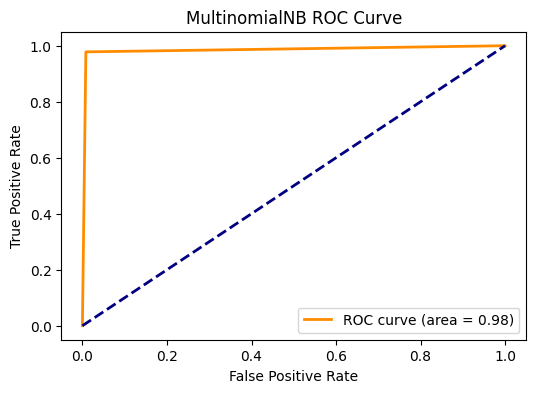

In [31]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, make_scorer, confusion_matrix, roc_curve, auc

mnb = MultinomialNB()
mnb.fit(X_train_tfidf, Y_train)
Y_res = mnb.predict(X_test_tfidf)

#we are using False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(Y_test, Y_res)
roc_auc = auc(fpr, tpr)

#utility variables for final table
mnb_accuracy = format(accuracy_score(Y_test, Y_res))
mnb_precision = format(precision_score(Y_test, Y_res))
mnb_recall = format(recall_score(Y_test, Y_res))
mnb_f1 = format(f1_score(Y_test, Y_res))

print('Classification accuracy {:.1%}'.format(accuracy_score(Y_test, Y_res)))
print("--------------------------")
print("Confusion matrix:\n", confusion_matrix(Y_test, Y_res))
print("--------------------------")
print(classification_report(Y_test, Y_res, target_names=['spam', 'ham']))

#printing roc curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MultinomialNB ROC Curve')
plt.legend(loc='lower right')
plt.show()

Classification accuracy 98.3%
--------------------------
Confusion matrix:
 [[4645  128]
 [  24 4349]]
--------------------------
              precision    recall  f1-score   support

        spam       0.99      0.97      0.98      4773
         ham       0.97      0.99      0.98      4373

    accuracy                           0.98      9146
   macro avg       0.98      0.98      0.98      9146
weighted avg       0.98      0.98      0.98      9146



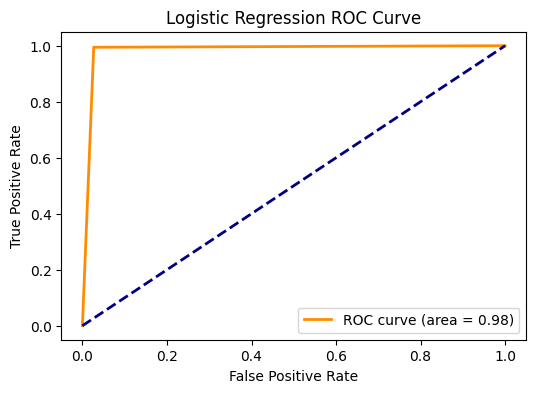

In [32]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=200)
lr.fit(X_train_tfidf, Y_train)
Y_res = lr.predict(X_test_tfidf)

#we are using False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(Y_test, Y_res)
roc_auc = auc(fpr, tpr)

#utility variables for final table
lr_accuracy = format(accuracy_score(Y_test, Y_res))
lr_precision = format(precision_score(Y_test, Y_res))
lr_recall = format(recall_score(Y_test, Y_res))
lr_f1 = format(f1_score(Y_test, Y_res))

print('Classification accuracy {:.1%}'.format(accuracy_score(Y_test, Y_res)))
print("--------------------------")
print("Confusion matrix:\n", confusion_matrix(Y_test, Y_res))
print("--------------------------")
print(classification_report(Y_test, Y_res, target_names=['spam', 'ham']))

#printing roc curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc='lower right')
plt.show()

Classification accuracy 98.9%
--------------------------
Confusion matrix:
 [[4688   85]
 [  19 4354]]
--------------------------
              precision    recall  f1-score   support

        spam       1.00      0.98      0.99      4773
         ham       0.98      1.00      0.99      4373

    accuracy                           0.99      9146
   macro avg       0.99      0.99      0.99      9146
weighted avg       0.99      0.99      0.99      9146



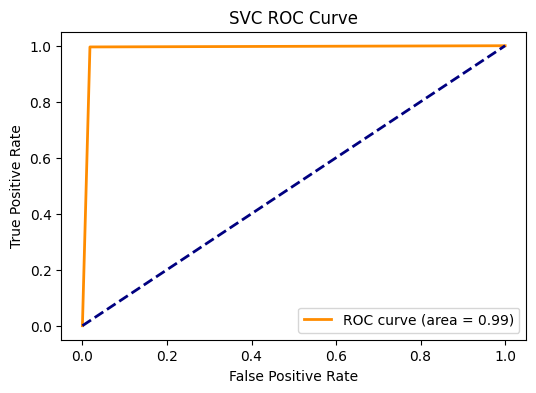

In [33]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train_tfidf, Y_train)
Y_res = svc.predict(X_test_tfidf)

#we are using False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(Y_test, Y_res)
roc_auc = auc(fpr, tpr)

#utility variables for final table
svc_accuracy = format(accuracy_score(Y_test, Y_res))
svc_precision = format(precision_score(Y_test, Y_res))
svc_recall = format(recall_score(Y_test, Y_res))
svc_f1 = format(f1_score(Y_test, Y_res))

print('Classification accuracy {:.1%}'.format(accuracy_score(Y_test, Y_res)))
print("--------------------------")
print("Confusion matrix:\n", confusion_matrix(Y_test, Y_res))
print("--------------------------")
print(classification_report(Y_test, Y_res, target_names=['spam', 'ham']))

#printing roc curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVC ROC Curve')
plt.legend(loc='lower right')
plt.show()

Classification accuracy 95.5%
--------------------------
Confusion matrix:
 [[4548  225]
 [ 184 4189]]
--------------------------
              precision    recall  f1-score   support

        spam       0.96      0.95      0.96      4773
         ham       0.95      0.96      0.95      4373

    accuracy                           0.96      9146
   macro avg       0.96      0.96      0.96      9146
weighted avg       0.96      0.96      0.96      9146



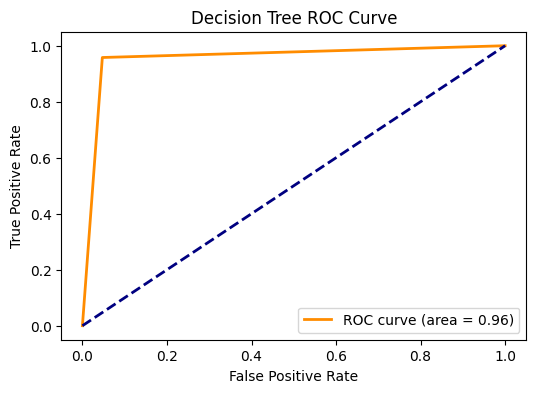

In [34]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dt = DecisionTreeClassifier()
dt.fit(X_train_tfidf, Y_train)
Y_res = dt.predict(X_test_tfidf)

#we are using False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(Y_test, Y_res)
roc_auc = auc(fpr, tpr)

#utility variables for final table
dt_accuracy = format(accuracy_score(Y_test, Y_res))
dt_precision = format(precision_score(Y_test, Y_res))
dt_recall = format(recall_score(Y_test, Y_res))
dt_f1 = format(f1_score(Y_test, Y_res))

print('Classification accuracy {:.1%}'.format(accuracy_score(Y_test, Y_res)))
print("--------------------------")
print("Confusion matrix:\n", confusion_matrix(Y_test, Y_res))
print("--------------------------")
print(classification_report(Y_test, Y_res, target_names=['spam', 'ham']))

#printing roc curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.legend(loc='lower right')
plt.show()

Classification accuracy 98.5%
--------------------------
Confusion matrix:
 [[4683   90]
 [  49 4324]]
--------------------------
              precision    recall  f1-score   support

        spam       0.99      0.98      0.99      4773
         ham       0.98      0.99      0.98      4373

    accuracy                           0.98      9146
   macro avg       0.98      0.98      0.98      9146
weighted avg       0.98      0.98      0.98      9146



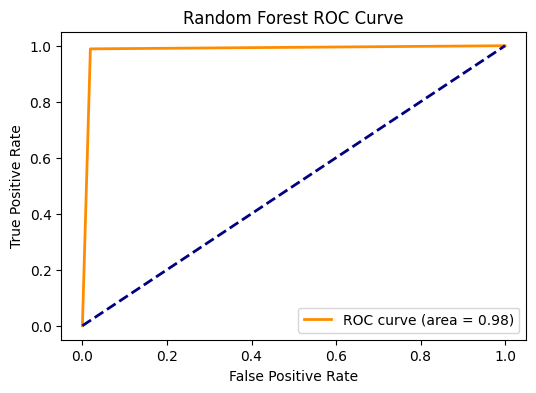

In [35]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train_tfidf, Y_train)
Y_res = rfc.predict(X_test_tfidf)

#we are using False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(Y_test, Y_res)
roc_auc = auc(fpr, tpr)

#utility variables for final table
rfc_accuracy = format(accuracy_score(Y_test, Y_res))
rfc_precision = format(precision_score(Y_test, Y_res))
rfc_recall = format(recall_score(Y_test, Y_res))
rfc_f1 = format(f1_score(Y_test, Y_res))

print('Classification accuracy {:.1%}'.format(accuracy_score(Y_test, Y_res)))
print("--------------------------")
print("Confusion matrix:\n", confusion_matrix(Y_test, Y_res))
print("--------------------------")
print(classification_report(Y_test, Y_res, target_names=['spam', 'ham']))

#printing roc curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [36]:
from tabulate import tabulate

classifiers = ['Multinomial Naive Bayesian', 'Logistic Regression', 'Support Vector Machine', 'Decision Tree Classifier', 'Random Forest Classifier']

#final table for comparing metrics of all the classifiers
accuracy_scores = [mnb_accuracy[0:6], lr_accuracy[0:6], svc_accuracy[0:6], dt_accuracy[0:6], rfc_accuracy[0:6]]

#accuracy table
accuracy_list = list(zip(classifiers, accuracy_scores))
accuracy_table = tabulate(accuracy_list, headers=['Classifier', 'Accuracy Score'], tablefmt='rounded_grid')

print(accuracy_table)

╭────────────────────────────┬──────────────────╮
│ Classifier                 │   Accuracy Score │
├────────────────────────────┼──────────────────┤
│ Multinomial Naive Bayesian │           0.9852 │
├────────────────────────────┼──────────────────┤
│ Logistic Regression        │           0.9833 │
├────────────────────────────┼──────────────────┤
│ Support Vector Machine     │           0.9886 │
├────────────────────────────┼──────────────────┤
│ Decision Tree Classifier   │           0.9552 │
├────────────────────────────┼──────────────────┤
│ Random Forest Classifier   │           0.9848 │
╰────────────────────────────┴──────────────────╯


In [37]:
#precision table
precision_scores = [mnb_precision[0:6], lr_precision[0:6], svc_precision[0:6], dt_precision[0:6], rfc_precision[0:6]]

precision_list = list(zip(classifiers, precision_scores))
precision_table = tabulate(precision_list, headers=['Classifier', 'Precision Score'], tablefmt='rounded_grid')

print(precision_table)

╭────────────────────────────┬───────────────────╮
│ Classifier                 │   Precision Score │
├────────────────────────────┼───────────────────┤
│ Multinomial Naive Bayesian │            0.9909 │
├────────────────────────────┼───────────────────┤
│ Logistic Regression        │            0.9714 │
├────────────────────────────┼───────────────────┤
│ Support Vector Machine     │            0.9808 │
├────────────────────────────┼───────────────────┤
│ Decision Tree Classifier   │            0.949  │
├────────────────────────────┼───────────────────┤
│ Random Forest Classifier   │            0.9796 │
╰────────────────────────────┴───────────────────╯


In [38]:
#recall table
recall_scores = [mnb_recall[0:6], lr_recall[0:6], svc_recall[0:6], dt_recall[0:6], rfc_recall[0:6]]

recall_list = list(zip(classifiers, recall_scores))
recall_table = tabulate(recall_list, headers=['Classifier', 'Recall Score'], tablefmt='rounded_grid')

print(recall_table)

╭────────────────────────────┬────────────────╮
│ Classifier                 │   Recall Score │
├────────────────────────────┼────────────────┤
│ Multinomial Naive Bayesian │         0.978  │
├────────────────────────────┼────────────────┤
│ Logistic Regression        │         0.9945 │
├────────────────────────────┼────────────────┤
│ Support Vector Machine     │         0.9956 │
├────────────────────────────┼────────────────┤
│ Decision Tree Classifier   │         0.9579 │
├────────────────────────────┼────────────────┤
│ Random Forest Classifier   │         0.9887 │
╰────────────────────────────┴────────────────╯


In [39]:
#f1 table
f1_scores = [mnb_f1[0:6], lr_f1[0:6], svc_f1[0:6], dt_f1[0:6], rfc_f1[0:6]]

f1_list = list(zip(classifiers, f1_scores))
f1_table = tabulate(f1_list, headers=['Classifier', 'f1 Score'], tablefmt='rounded_grid')

print(f1_table)

╭────────────────────────────┬────────────╮
│ Classifier                 │   f1 Score │
├────────────────────────────┼────────────┤
│ Multinomial Naive Bayesian │     0.9844 │
├────────────────────────────┼────────────┤
│ Logistic Regression        │     0.9828 │
├────────────────────────────┼────────────┤
│ Support Vector Machine     │     0.9881 │
├────────────────────────────┼────────────┤
│ Decision Tree Classifier   │     0.9534 │
├────────────────────────────┼────────────┤
│ Random Forest Classifier   │     0.9841 │
╰────────────────────────────┴────────────╯


We have seen that we have small variations for each classifier, except for SVC for which the Classification accuracy has improved significantly with respect to the previous case so we decided to apply the K-fold Validation with TF-IDF.

##Step 4.2: k-fold Cross Validation

In order to have a more accurate estimation among all the classifiers we decided to use the K-fold cross validation using 10 folds.


In [40]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline

#we create 10 folds
n_folds = 10
skf = StratifiedKFold(n_folds)

In [41]:
#K-fold Cross Validation on MNB

mnb_pipe = Pipeline([
    ('TfidfVect', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

mnb_scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}

mnb_count = cross_validate(
    mnb_pipe,
    train_ds['email'],
    train_ds['label'],
    scoring=mnb_scoring,
    return_estimator=True,
    cv=skf,
    n_jobs= -1
)

mnb_results = pd.DataFrame({
    'Accuracy': mnb_count['test_accuracy'],
    'Precision': mnb_count['test_precision'],
    'Recall': mnb_count['test_recall'],
    'F1 Score': mnb_count['test_f1_score']
})

print("Metrics Scores Across Folds:")
print(mnb_results)
print('-------------------------------------------')
print("Mean Metrics Across Folds:")

mnb_mean = mnb_results.mean()
print(mnb_mean)

Metrics Scores Across Folds:
   Accuracy  Precision    Recall  F1 Score
0  0.985569   0.990291  0.979424  0.984828
1  0.982617   0.988866  0.974623  0.981693
2  0.987537   0.995119  0.978738  0.986860
3  0.989833   0.993089  0.985597  0.989329
4  0.986225   0.993724  0.977366  0.985477
5  0.986877   0.989634  0.982841  0.986226
6  0.984252   0.990257  0.976664  0.983414
7  0.988517   0.994437  0.981469  0.987910
8  0.988189   0.993060  0.982155  0.987578
9  0.985564   0.989605  0.980096  0.984828
-------------------------------------------
Mean Metrics Across Folds:
Accuracy     0.986518
Precision    0.991808
Recall       0.979897
F1 Score     0.985814
dtype: float64


In [42]:
#utility variable for Wilcoxon test
mnb_accuracy_list = mnb_results['Accuracy']
mnb_accuracy_list

0    0.985569
1    0.982617
2    0.987537
3    0.989833
4    0.986225
5    0.986877
6    0.984252
7    0.988517
8    0.988189
9    0.985564
Name: Accuracy, dtype: float64

In [43]:
#K-fold Cross Validation on Logistic Regression

lr_pipe = Pipeline([
    ('TfidfVect', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

lr_scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}

lr_count = cross_validate(
    lr_pipe,
    train_ds['email'],
    train_ds['label'],
    scoring=lr_scoring,
    return_estimator=True,
    cv=skf,
    n_jobs= -1
)

lr_results = pd.DataFrame({
    'Accuracy': lr_count['test_accuracy'],
    'Precision': lr_count['test_precision'],
    'Recall': lr_count['test_recall'],
    'F1 Score': lr_count['test_f1_score']
})

print("Metrics Scores Across Folds:")
print(lr_results)
print('-------------------------------------------')
print("Mean Metrics Across Folds:")

lr_mean = lr_results.mean()
print(lr_mean)

Metrics Scores Across Folds:
   Accuracy  Precision    Recall  F1 Score
0  0.986881   0.977120  0.995885  0.986413
1  0.983273   0.970569  0.995199  0.982729
2  0.987537   0.980379  0.993827  0.987057
3  0.986881   0.976478  0.996571  0.986422
4  0.984257   0.973790  0.993827  0.983707
5  0.984908   0.973808  0.995196  0.984386
6  0.984580   0.973790  0.994509  0.984041
7  0.985892   0.976415  0.994509  0.985379
8  0.986549   0.977733  0.994509  0.986050
9  0.984252   0.973773  0.993823  0.983696
-------------------------------------------
Mean Metrics Across Folds:
Accuracy     0.985501
Precision    0.975385
Recall       0.994785
F1 Score     0.984988
dtype: float64


In [44]:
#utility variable for Wilcoxon test
lr_accuracy_list = lr_results['Accuracy']
lr_accuracy_list

0    0.986881
1    0.983273
2    0.987537
3    0.986881
4    0.984257
5    0.984908
6    0.984580
7    0.985892
8    0.986549
9    0.984252
Name: Accuracy, dtype: float64

In [50]:
#K-fold Cross Validation on SVC

svc_pipe = Pipeline([
    ('TfidfVect', TfidfVectorizer()),
    ('clf', SVC())
])

svc_scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}

svc_count = cross_validate(
    svc_pipe,
    train_ds['email'],
    train_ds['label'],
    scoring=svc_scoring,
    return_estimator=True,
    cv=skf,
    n_jobs= -1
)

svc_results = pd.DataFrame({
    'Accuracy': svc_count['test_accuracy'],
    'Precision': svc_count['test_precision'],
    'Recall': svc_count['test_recall'],
    'F1 Score': svc_count['test_f1_score']
})

print("Metrics Scores Across Folds:")
print(svc_results)
print('-------------------------------------------')
print("Mean Metrics Across Folds:")

svc_mean = svc_results.mean()
print(svc_mean)

Metrics Scores Across Folds:
   Accuracy  Precision    Recall  F1 Score
0  0.990817   0.985075  0.995885  0.990450
1  0.990817   0.983108  0.997942  0.990470
2  0.988521   0.983028  0.993141  0.988059
3  0.991801   0.985105  0.997942  0.991482
4  0.989177   0.981744  0.995885  0.988764
5  0.988517   0.981055  0.995196  0.988075
6  0.992126   0.986422  0.997255  0.991809
7  0.989829   0.982409  0.996568  0.989438
8  0.989173   0.983696  0.993823  0.988733
9  0.989829   0.983718  0.995196  0.989423
-------------------------------------------
Mean Metrics Across Folds:
Accuracy     0.990061
Precision    0.983536
Recall       0.995883
F1 Score     0.989670
dtype: float64


In [51]:
#utility variable for Wilcoxon test
svc_accuracy_list = svc_results['Accuracy']
svc_accuracy_list

0    0.990817
1    0.990817
2    0.988521
3    0.991801
4    0.989177
5    0.988517
6    0.992126
7    0.989829
8    0.989173
9    0.989829
Name: Accuracy, dtype: float64

In [46]:
#K-fold Cross Validation on Decision Tree Classifier

dt_pipe = Pipeline([
    ('TfidfVect', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier())
])

dt_scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}

dt_count = cross_validate(
    dt_pipe,
    train_ds['email'],
    train_ds['label'],
    scoring=dt_scoring,
    return_estimator=True,
    cv=skf,
    n_jobs= -1
)

dt_results = pd.DataFrame({
    'Accuracy': dt_count['test_accuracy'],
    'Precision': dt_count['test_precision'],
    'Recall': dt_count['test_recall'],
    'F1 Score': dt_count['test_f1_score']
})

print("Metrics Scores Across Folds:")
print(dt_results)
print('--------------------------------------------')
print("Mean Metrics Across Folds:")

dt_mean = dt_results.mean()
print(dt_mean)

Metrics Scores Across Folds:
   Accuracy  Precision    Recall  F1 Score
0  0.954411   0.944707  0.960905  0.952737
1  0.947524   0.945742  0.944444  0.945093
2  0.955067   0.958362  0.947188  0.952742
3  0.954083   0.955740  0.947874  0.951791
4  0.954411   0.953889  0.950617  0.952250
5  0.944882   0.941136  0.943720  0.942426
6  0.950459   0.940027  0.957447  0.948657
7  0.952756   0.947512  0.954015  0.950752
8  0.946850   0.945017  0.943720  0.944368
9  0.951115   0.949794  0.947838  0.948815
--------------------------------------------
Mean Metrics Across Folds:
Accuracy     0.951156
Precision    0.948193
Recall       0.949777
F1 Score     0.948963
dtype: float64


In [47]:
#utility variable for Wilcoxon test
dt_accuracy_list = dt_results['Accuracy']
dt_accuracy_list

0    0.954411
1    0.947524
2    0.955067
3    0.954083
4    0.954411
5    0.944882
6    0.950459
7    0.952756
8    0.946850
9    0.951115
Name: Accuracy, dtype: float64

In [48]:
#K-fold Cross Validation on Random Forest Classifier

rfc_pipe = Pipeline([
    ('TfidfVect', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

rfc_scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}

rfc_count = cross_validate(
    rfc_pipe,
    train_ds['email'],
    train_ds['label'],
    scoring=rfc_scoring,
    return_estimator=True,
    cv=skf,
    n_jobs= -1
)

rfc_results = pd.DataFrame({
    'Accuracy': rfc_count['test_accuracy'],
    'Precision': rfc_count['test_precision'],
    'Recall': rfc_count['test_recall'],
    'F1 Score': rfc_count['test_f1_score']
})

print("Metrics Scores Across Folds:")
print(rfc_results)
print('--------------------------------------------')
print("Mean Metrics Across Folds:")

rfc_mean = rfc_results.mean()
print(rfc_mean)

Metrics Scores Across Folds:
   Accuracy  Precision    Recall  F1 Score
0  0.985897   0.984921  0.985597  0.985259
1  0.982617   0.977566  0.986283  0.981905
2  0.984257   0.983539  0.983539  0.983539
3  0.987537   0.984311  0.989712  0.987004
4  0.983601   0.982853  0.982853  0.982853
5  0.981955   0.979480  0.982841  0.981158
6  0.986220   0.982277  0.989019  0.985636
7  0.984252   0.981545  0.985587  0.983562
8  0.982940   0.979522  0.984900  0.982204
9  0.988517   0.988324  0.987646  0.987985
--------------------------------------------
Mean Metrics Across Folds:
Accuracy     0.984779
Precision    0.982434
Recall       0.985798
F1 Score     0.984110
dtype: float64


In [49]:
#utility variable for Wilcoxon test
rfc_accuracy_list = rfc_results['Accuracy']
rfc_accuracy_list

0    0.985897
1    0.982617
2    0.984257
3    0.987537
4    0.983601
5    0.981955
6    0.986220
7    0.984252
8    0.982940
9    0.988517
Name: Accuracy, dtype: float64

In [52]:
#mean accuracy table
acc_mean_scores = [np.round(mnb_mean[0], 4), np.round(lr_mean[0], 4), np.round(svc_mean[0], 4), np.round(dt_mean[0], 4), np.round(rfc_mean[0], 4)]

acc_mean_list = list(zip(classifiers, acc_mean_scores))
acc_mean_table = tabulate(acc_mean_list, headers=['Classifier', 'Mean Accuracy Score'], tablefmt='rounded_grid')

print(acc_mean_table)

╭────────────────────────────┬───────────────────────╮
│ Classifier                 │   Mean Accuracy Score │
├────────────────────────────┼───────────────────────┤
│ Multinomial Naive Bayesian │                0.9865 │
├────────────────────────────┼───────────────────────┤
│ Logistic Regression        │                0.9855 │
├────────────────────────────┼───────────────────────┤
│ Support Vector Machine     │                0.9901 │
├────────────────────────────┼───────────────────────┤
│ Decision Tree Classifier   │                0.9512 │
├────────────────────────────┼───────────────────────┤
│ Random Forest Classifier   │                0.9848 │
╰────────────────────────────┴───────────────────────╯


In [53]:
#mean precision table
prec_mean_scores = [np.round(mnb_mean[1], 4), np.round(lr_mean[1], 4), np.round(svc_mean[1], 4), np.round(dt_mean[1], 4), np.round(rfc_mean[1], 4)]

prec_mean_list = list(zip(classifiers, prec_mean_scores))
prec_mean_table = tabulate(prec_mean_list, headers=['Classifier', 'Mean Precision Score'], tablefmt='rounded_grid')

print(prec_mean_table)

╭────────────────────────────┬────────────────────────╮
│ Classifier                 │   Mean Precision Score │
├────────────────────────────┼────────────────────────┤
│ Multinomial Naive Bayesian │                 0.9918 │
├────────────────────────────┼────────────────────────┤
│ Logistic Regression        │                 0.9754 │
├────────────────────────────┼────────────────────────┤
│ Support Vector Machine     │                 0.9835 │
├────────────────────────────┼────────────────────────┤
│ Decision Tree Classifier   │                 0.9482 │
├────────────────────────────┼────────────────────────┤
│ Random Forest Classifier   │                 0.9824 │
╰────────────────────────────┴────────────────────────╯


In [54]:
#mean recall table
rec_mean_scores = [np.round(mnb_mean[2], 4), np.round(lr_mean[2], 4), np.round(svc_mean[2], 4), np.round(dt_mean[2], 4), np.round(rfc_mean[2], 4)]

rec_mean_list = list(zip(classifiers, rec_mean_scores))
rec_mean_table = tabulate(rec_mean_list, headers=['Classifier', 'Mean Recall Score'], tablefmt='rounded_grid')

print(rec_mean_table)

╭────────────────────────────┬─────────────────────╮
│ Classifier                 │   Mean Recall Score │
├────────────────────────────┼─────────────────────┤
│ Multinomial Naive Bayesian │              0.9799 │
├────────────────────────────┼─────────────────────┤
│ Logistic Regression        │              0.9948 │
├────────────────────────────┼─────────────────────┤
│ Support Vector Machine     │              0.9959 │
├────────────────────────────┼─────────────────────┤
│ Decision Tree Classifier   │              0.9498 │
├────────────────────────────┼─────────────────────┤
│ Random Forest Classifier   │              0.9858 │
╰────────────────────────────┴─────────────────────╯


In [55]:
#mean f1 table
f1_mean_scores = [np.round(mnb_mean[3], 4), np.round(lr_mean[3], 4), np.round(svc_mean[3], 4), np.round(dt_mean[3], 4), np.round(rfc_mean[3], 4)]

f1_mean_list = list(zip(classifiers, f1_mean_scores))
f1_mean_table = tabulate(f1_mean_list, headers=['Classifier', 'Mean F1 Score'], tablefmt='rounded_grid')

print(f1_mean_table)

╭────────────────────────────┬─────────────────╮
│ Classifier                 │   Mean F1 Score │
├────────────────────────────┼─────────────────┤
│ Multinomial Naive Bayesian │          0.9858 │
├────────────────────────────┼─────────────────┤
│ Logistic Regression        │          0.985  │
├────────────────────────────┼─────────────────┤
│ Support Vector Machine     │          0.9897 │
├────────────────────────────┼─────────────────┤
│ Decision Tree Classifier   │          0.949  │
├────────────────────────────┼─────────────────┤
│ Random Forest Classifier   │          0.9841 │
╰────────────────────────────┴─────────────────╯


# Step 5: Validation

We decided to apply the Wilcoxon test in order to understand if the classifiers are different from a statistical point of view and see which one of them is better.

##MNB Classifier Comparison

In [56]:
from scipy.stats import wilcoxon
wilcoxon(mnb_accuracy_list, lr_accuracy_list)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=6.0, pvalue=0.050612432239184685)

In [57]:
wilcoxon(mnb_accuracy_list, svc_accuracy_list)

WilcoxonResult(statistic=0.0, pvalue=0.001953125)

In [58]:
wilcoxon(mnb_accuracy_list, dt_accuracy_list)

WilcoxonResult(statistic=0.0, pvalue=0.001953125)

In [59]:
wilcoxon(mnb_accuracy_list, rfc_accuracy_list)

WilcoxonResult(statistic=8.0, pvalue=0.08583095844428565)

## Logistic Regression Classifier Comparison

In [60]:
wilcoxon(lr_accuracy_list, svc_accuracy_list)

WilcoxonResult(statistic=0.0, pvalue=0.001953125)

In [61]:
wilcoxon(lr_accuracy_list, dt_accuracy_list)

WilcoxonResult(statistic=0.0, pvalue=0.001953125)

In [62]:
wilcoxon(lr_accuracy_list, rfc_accuracy_list)

WilcoxonResult(statistic=17.0, pvalue=0.322265625)

##SVC Classifier Comparison

In [63]:
wilcoxon(svc_accuracy_list, dt_accuracy_list)

WilcoxonResult(statistic=0.0, pvalue=0.001953125)

In [64]:
wilcoxon(svc_accuracy_list, rfc_accuracy_list)

WilcoxonResult(statistic=0.0, pvalue=0.001953125)

##Decision Tree Classifier Comparison

In [65]:
wilcoxon(dt_accuracy_list, rfc_accuracy_list)

WilcoxonResult(statistic=0.0, pvalue=0.001953125)

Every Wilcoxon test, except for 3 of them, give a ***p-value*** that is lower than the confidence level α (tipically 0.05) so we can reject the Null Hypothesis and we can conclude that the result is statistically significant.
So we can identify the best classifier as the one that will have the lowest error rate.

N.B.: For the tests that had a ***p-value*** higher than α  we cannot reject the null hypothesis.

In [66]:
#Computing error rate for the classifiers
mnb_err_rate = 1 - np.round(mnb_mean[0], 4)
lr_err_rate = 1 - np.round(lr_mean[0], 4)
svc_err_rate = 1 - np.round(svc_mean[0], 4)
dt_err_rate = 1 - np.round(dt_mean[0], 4)
rfc_err_rate = 1 - np.round(rfc_mean[0], 4)

print('MNB Error Rate')
print(np.round(mnb_err_rate, 4))
print('---------------------------------------')
print('Logistic Regression Error rate')
print(np.round(lr_err_rate, 4))
print('---------------------------------------')
print('SVC Error rate')
print(np.round(svc_err_rate, 4))
print('---------------------------------------')
print('Decision Tree Classifier Error rate')
print(np.round(dt_err_rate, 4))
print('---------------------------------------')
print('Random Forest Classifier Error rate')
print(np.round(rfc_err_rate, 4))

MNB Error Rate
0.0135
---------------------------------------
Logistic Regression Error rate
0.0145
---------------------------------------
SVC Error rate
0.0099
---------------------------------------
Decision Tree Classifier Error rate
0.0488
---------------------------------------
Random Forest Classifier Error rate
0.0152


# Step 6: Reporting

We have seen that all the classifier that we have used have obtained optimal values for the considered metrics. This is in accordance with the following articles:

- https://ieeexplore.ieee.org/abstract/document/9528108 (similar results for MNB, SVC and Random Forest)

- https://ieeexplore.ieee.org/abstract/document/9183098?casa_token=uGWWHcFqThcAAAAA:2_G1jduC26CrFo1KsCRSnztcOoUtkHDAm9_JQTtmT5kEWM9E-_XHYfLFsL7VUEiphcpgY_vyxL0
(similar results for MNB, DT e RF)

- https://www.sciencedirect.com/science/article/pii/S1877050921013016
(similar results for each classifier)

- https://ieeexplore.ieee.org/abstract/document/9850588
(similar results for each classifier)

In these articles we can see that the values indicated are not so far from the ones that we have (few % point). We have noticed also that the best classifier are usually the same so, MNB, Logistic Regression and Random Forest.

#Realtime Software: Classification

We create a real time classificator that exploits the classifier that performed better in order to classify a given text.

We choose to use the software on the MNB because it was the one with the highest value of accuracy.

In [68]:
import joblib

joblib.dump(svc_count['estimator'][0], 'spam_detection_model.joblib')

['spam_detection_model.joblib']

In [69]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

#referring to SVM Classifier
loaded_model = joblib.load('spam_detection_model.joblib')
loaded_classifier = loaded_model.named_steps['clf']
loaded_count_vectorizer = loaded_model.named_steps['TfidfVect']

for i in range(2):
  new_email_text = input("\nPlease enter a new email:\n")
  new_email_vectorized = loaded_count_vectorizer.transform([new_email_text])

  prediction = loaded_classifier.predict(new_email_vectorized)

  if prediction:
    print(f"\nThe email has been classified as Spam")
  else:
    print(f"\nThe email has been classified as Ham")


Please enter a new email:
Subject: Meeting Tomorrow Hi Emily, I hope this email finds you well. We have a team meeting scheduled for tomorrow at 10 AM in the conference room. We'll be discussing the latest project updates and addressing any questions or concerns you may have. Please come prepared with your progress report and any items you'd like to discuss. If you're unable to attend, please let me know in advance. Looking forward to a productive meeting. Best regards, Bob.

The email has been classified as Ham

Please enter a new email:
Subject:  Triple Your Income Instantly - Limited Slots Available! Dear Luke, Unbelievable opportunity awaits you!  We guarantee to triple your income in just 24 hours! Join our exclusive money-making program now and watch your bank account soar to new heights. Act fast, as we have limited slots available for this once-in-a-lifetime offer! Benefits: Instant riches, Financial freedom, Luxurious lifestyle. To secure your spot, click the link below and d